# Neural Networks with Numpy: Initialization, Regularization, Optimization Methods and Minibatch

The goal of this exercise is to show different initialization methods like he, xavier; regularization methods such as l2 regularization and drop out; optimization methods such as gradient descent, momentum, rmsprop and adam together with minibatch. This exercise will be very simple. Using MNIST, I will be predicting weather the image contains the number 1 or not.   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random

In [2]:
MNIST = pd.read_csv('G:\\MNIST\\MNIST_train.csv')

In [3]:
MNIST.shape

(42000, 785)

#### Right now we can see that there are 10 classes

In [4]:
MNIST.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

#### I will convert all the digits beside the number one into the number zero.

In [5]:
def convert_to_zero(data):
    if data['label'] != 1:
        label = 0
    else:
        label = 1
    return label

In [6]:
MNIST['label'] = MNIST.apply(convert_to_zero,axis=1)

In [7]:
def ones_only(data):
    if data['label'] == 1:
        label1 = 1
    else:
        label1 = np.random.uniform()
    return label1

In [8]:
MNIST['label1'] = MNIST.apply(ones_only,axis=1)

In [9]:
MNIST = MNIST.sort_values(by='label1',ascending=False)

In [10]:
MNIST = MNIST[:9368]

In [11]:
MNIST = MNIST.drop(['label1'],axis=1)

#### Now we only have the classes one and zero

In [12]:
MNIST.label.value_counts()

1    4684
0    4684
Name: label, dtype: int64

In [13]:
MNIST.shape

(9368, 785)

#### I will now divide the data into train and test sets. I will not make a dev set since this is not the focus of this exercise

In [14]:
MNIST['permutation'] = np.random.permutation(9368)

In [15]:
MNIST[MNIST.permutation<936].label.value_counts()

1    471
0    465
Name: label, dtype: int64

In [16]:
test = MNIST[MNIST.permutation<936]

In [17]:
train = MNIST[MNIST.permutation>936]

In [18]:
train_x = train.drop('label', 1)
train_x = train_x.drop('permutation', 1)
train_x = train_x/255
train_x = train_x.T

train_y = train['label']
train_y = train_y.values.reshape((1,train_y.shape[0]))

test_x = test.drop('label', 1)
test_x = test_x.drop('permutation', 1)
test_x = test_x/255
test_x = test_x.T
test_y = test['label']
test_y = test_y.values.reshape((1,test_y.shape[0]))


## Data

In [19]:
train_x.head()

,0,19215,19083,19094,19099,19106,3735,19117,19128,19133,...,41845,19957,4852,30128,38171,21353,1512,5495,25700,13190
pixel0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pixel1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pixel2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pixel3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pixel4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
train_y

array([[1, 1, 1, ..., 0, 0, 0]], dtype=int64)

#### Sample of the Number 1

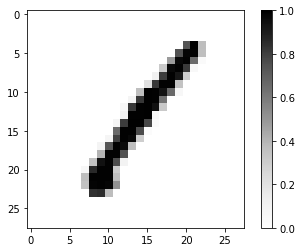

In [21]:
grid_data = train_x.iloc[:,0].as_matrix().reshape(28,28)
plt.imshow(grid_data, interpolation = "none", cmap = "Greys")
plt.colorbar()

#### Sample of Not the Number 1

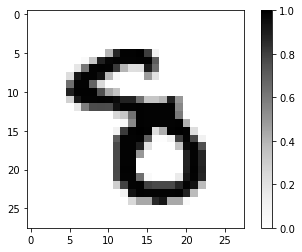

In [22]:
grid_data = train_x.iloc[:,5000].as_matrix().reshape(28,28)
plt.imshow(grid_data, interpolation = "none", cmap = "Greys")
plt.colorbar()

## Model

In [23]:
def initialize_parameters(layer_dims,initialization,keep_prob):
    
    parameters = {}
    L = len(layer_dims)           

    for l in range(1, L):
        
        if initialization == "random":
            parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
            parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
            
        elif initialization == "he":
            parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])*.01
            parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
            
        elif initialization == "xavier":
            parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(1/layer_dims[l-1])*.01
            parameters['b' + str(l)] = np.zeros((layer_dims[l],1))          
        
        drop_out = np.random.rand(layer_dims[l],layer_dims[l-1])
        parameters['D' + str(l)] = drop_out < keep_prob 
        parameters['W' + str(l)] = parameters['W' + str(l)]*parameters['D' + str(l)]                           
        parameters['W' + str(l)] = parameters['W' + str(l)]/keep_prob
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters
    
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    assert(Z.shape == (W.shape[0], A.shape[1]))
    return Z, cache

def relu(z):
    r = z * (z > 0)
    return r,z 

def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s,z

def tanh(z):
    t = (2/(1+np.exp(-z))) - 1
    return t,z

def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        A, activation_cache = relu(Z)
        
    elif activation == "tanh":
        A, activation_cache = tanh(Z)
    
    else:
        print("Error in Activation")
    
    cache = (linear_cache, activation_cache)
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    return A, cache

def L_model_forward(X, parameters,activation):
    caches = []
    A = X
    L = len(activation) 
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters['W' + str(l)], parameters['b' + str(l)], activation=activation[l-1])
        caches.append(cache)
    AL, cache = linear_activation_forward(A,parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
    assert (L == len(activation))
    return AL, caches

def compute_cost_L2(AL, Y,lambd,layer_dims,parameters):
    m = Y.shape[1]
    L = len(layer_dims)    
    sum_W=0
    
    if lambd == 0:
        cost = -(1/m)*np.sum((Y*np.log(AL))+((1-Y)*np.log(1-AL)))
    else:
        for l in range(1, L):
            sum_W = sum_W + np.sum(np.square(parameters['W' + str(l)])) 
        L2_regularization_cost = (1/m)*(lambd/2)*sum_W
        cost = -(1/m)*np.sum((Y*np.log(AL))+((1-Y)*np.log(1-AL)))+L2_regularization_cost
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0 
    
    assert (dZ.shape == Z.shape)
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    return dZ

def tanh_backward(dA, cache):
    Z = cache
    s = np.tanh(-Z)
    dZ = 1 - (s**2)
    
    assert (dZ.shape == Z.shape)
    return dZ

def linear_backward(dZ, cache,lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    
    if lambd != 0:
        dW = dW + (lambd*W/m)
    
    db = (1/m)*np.sum(dZ,axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, lambd,activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db =  linear_backward(dZ, linear_cache,lambd)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db =  linear_backward(dZ, linear_cache,lambd)
        
    elif activation == "tanh":
        dZ = tanh_backward(dA,activation_cache)
        dA_prev, dW, db =  linear_backward(dZ, linear_cache,lambd)
    
    return dA_prev, dW, db

def model_backward(AL, Y, caches,lambd,activation,parameters,keep_prob):

    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
    
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,lambd=lambd, activation = 'sigmoid')
    grads["dW" + str(L)] = grads["dW" + str(L)]*parameters['D' + str(L)] 
    grads["dW" + str(L)] = grads["dW" + str(L)]/keep_prob 

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache,lambd=lambd, activation = activation[l])
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["dW" + str(l + 1)] = grads["dW" + str(l + 1)]*parameters['D' + str(l + 1)] 
        grads["dW" + str(l + 1)] = grads["dW" + str(l + 1)]/keep_prob 
        grads["db" + str(l + 1)] = db_temp
        
    return grads

def update_parameters(parameters, grads, learning_rate):
    L = len(activation) 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate* grads["dW" + str(l + 1)] 
        parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate* grads["db" + str(l + 1)] 
        
    return parameters

def initialize_velocity(parameters,activation):
    L = len(activation) 
    v = {}

    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        
    return v

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate,activation):

    L = len(activation) 

    for l in range(L):

        v["dW" + str(l+1)] = beta*v['dW' + str(l+1)] + (1-beta)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v['db' + str(l+1)] + (1-beta)*grads['db' + str(l+1)]

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v["dW" + str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v["db" + str(l+1)] 

    return parameters, v

def initialize_adam(parameters) :

    L = len(activation) 
    v = {}
    s = {}

    for l in range(L):

        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,beta1, beta2, epsilon):
    L = len(activation) 
    v_corrected = {}                     
    s_corrected = {}                    

    for l in range(L):

        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1-beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1-beta1)*grads['db' + str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-beta1**t)

        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2)*grads['dW' + str(l+1)]**2
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2)*grads['db' + str(l+1)]**2

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-beta2**t)

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*(v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)]+epsilon)))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*(v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)]+epsilon)))

    return parameters, v, s


def random_mini_batches(X, Y, mini_batch_size,seed = 0):    
    
    np.random.seed(seed)
    m = X.shape[1]            
    mini_batches = []
 
    permutation = list(np.random.permutation(m))
    shuffled_X = X.iloc[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X.iloc[:,(k*mini_batch_size):((k+1)*mini_batch_size)]
        mini_batch_Y = shuffled_Y[:,(k*mini_batch_size):((k+1)*mini_batch_size)]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    

    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X.iloc[:, -( m - (mini_batch_size * math.floor(m/mini_batch_size) ) ) ]
        mini_batch_Y = shuffled_Y[:, -( m - (mini_batch_size * math.floor(m/mini_batch_size) ) ) ]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def L_layer_model_L2(X, Y, layer_dims,activation, initialization,keep_prob,mini_batch_size,
                     test_x, test_y,
                     lambd=0,learning_rate = 0.0075, 
                     num_iterations = 3000,print_cost=False,beta=.9,optimizer="gd",beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    costs = []    
    train_accuracies = []
    test_accuracies = []
    t = 0
    seed = 0
    parameters = initialize_parameters(layer_dims,initialization,keep_prob)
    v = initialize_velocity(parameters,activation)
    v,s = initialize_adam(parameters)
    num_batches = X.shape[1] // mini_batch_size

    mini_batches = random_mini_batches(X, Y, mini_batch_size)

    for i in range(0, num_iterations):
        random_shuffle = np.arange(0, num_batches)
        random.shuffle(random_shuffle)
        for j in random_shuffle:

            AL, caches = L_model_forward(mini_batches[j][0], parameters,activation)

            cost = compute_cost_L2(AL, mini_batches[j][1], lambd,layer_dims,parameters)

            grads = model_backward(AL, mini_batches[j][1], caches,lambd,activation,parameters,keep_prob)
            
            if optimizer == 'gd':
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == 'momentum':
                parameters,v =  update_parameters_with_momentum(parameters, grads, v, beta, learning_rate,activation)

            elif optimizer == 'adam':
                t = t + 1
                parameters,v,s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,
                                beta1, beta2, epsilon)
            
            if print_cost and i % 10 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                
                m = X.shape[1]
                n = len(parameters) // 2 
                p_train = np.zeros((1,m))
                p_test = np.zeros((1,test_x.shape[1]))
                probas_train, caches = L_model_forward(train_x, parameters,activation)
                probas_test, caches = L_model_forward(test_x, parameters,activation)
                
                for i in range(0, probas_train.shape[1]):
                    if probas_train[0,i] > 0.5:
                        p_train[0,i] = 1
                    else:
                        p_train[0,i] = 0
                        
                for i in range(0, probas_test.shape[1]):
                    if probas_test[0,i] > 0.5:
                        p_test[0,i] = 1
                    else:
                        p_test[0,i] = 0
                        
                train_accuracy = (np.sum((p_train == train_y)/m))
                test_accuracy = (np.sum((p_test == test_y)/test_x.shape[1]))
        
                costs.append(cost)
                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)
                
    plt.plot(np.squeeze(costs),label = "cost")
    plt.plot(np.squeeze(train_accuracies), label = "train accuracy")
    plt.plot(np.squeeze(train_accuracies), label = "test accuracy")
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.legend()
    plt.show()
    
    return parameters

def predict(X, y, parameters,activation):

    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters,activation)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        
        else:
            p[0,i] = 0

    print("Number of Ones = "+str(np.sum(p)))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
    return

### Plain DNN

Cost after iteration 0: 0.693175
Cost after iteration 10: 0.693023
Cost after iteration 20: 0.692863
Cost after iteration 30: 0.692677
Cost after iteration 40: 0.692436
Cost after iteration 50: 0.692099
Cost after iteration 60: 0.691600
Cost after iteration 70: 0.690813
Cost after iteration 80: 0.689491
Cost after iteration 90: 0.687101
Cost after iteration 100: 0.682363
Cost after iteration 110: 0.671790
Cost after iteration 120: 0.644793
Cost after iteration 130: 0.573433
Cost after iteration 140: 0.452636
Cost after iteration 150: 0.350813
Cost after iteration 160: 0.266873
Cost after iteration 170: 0.189001
Cost after iteration 180: 0.134610
Cost after iteration 190: 0.106186
Cost after iteration 200: 0.091394
Cost after iteration 210: 0.082853
Cost after iteration 220: 0.077389
Cost after iteration 230: 0.073587
Cost after iteration 240: 0.070766
Cost after iteration 250: 0.068566
Cost after iteration 260: 0.066783
Cost after iteration 270: 0.065291
Cost after iteration 280: 0.064

Cost after iteration 2310: 0.020634
Cost after iteration 2320: 0.020459
Cost after iteration 2330: 0.020286
Cost after iteration 2340: 0.020115
Cost after iteration 2350: 0.019944
Cost after iteration 2360: 0.019775
Cost after iteration 2370: 0.019607
Cost after iteration 2380: 0.019440
Cost after iteration 2390: 0.019275
Cost after iteration 2400: 0.019111
Cost after iteration 2410: 0.018949
Cost after iteration 2420: 0.018787
Cost after iteration 2430: 0.018628
Cost after iteration 2440: 0.018469
Cost after iteration 2450: 0.018313
Cost after iteration 2460: 0.018157
Cost after iteration 2470: 0.018003
Cost after iteration 2480: 0.017851
Cost after iteration 2490: 0.017700
Cost after iteration 2500: 0.017551
Cost after iteration 2510: 0.017403
Cost after iteration 2520: 0.017257
Cost after iteration 2530: 0.017112
Cost after iteration 2540: 0.016969
Cost after iteration 2550: 0.016827
Cost after iteration 2560: 0.016687
Cost after iteration 2570: 0.016548
Cost after iteration 2580: 0

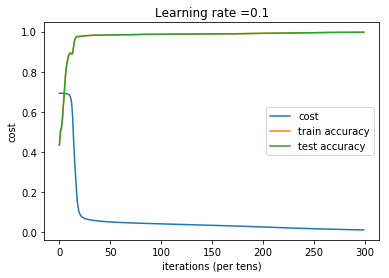

Wall time: 6min


In [24]:
%%time
layer_dims = [train_x.shape[0],128,128,1]
activation = ["relu","relu","sigmoid"]

parameters = L_layer_model_L2(X=train_x,Y=train_y, 
                              layer_dims=layer_dims,
                              activation=activation,
                              initialization='random',
                              keep_prob=1,
                              mini_batch_size = 8431,
                              test_x=test_x, test_y=test_y,
                              learning_rate = .1, lambd=0, 
                              num_iterations = 3000, print_cost = True,
                              optimizer='gd')


In [25]:
predict(train_x, train_y, parameters,activation)

Number of Ones = 4212.0
Accuracy: 0.997034752698


In [26]:
predict(test_x, test_y, parameters,activation)

Number of Ones = 475.0
Accuracy: 0.987179487179


#### This took almost 6.5 minutes. However, there is a one percent discrepancy between the training accuracy and testing accuracy. There is a sign of slight overfitting.

# ALL METHODS

Cost after iteration 0: 0.693158
Cost after iteration 10: 0.049765
Cost after iteration 20: 0.039508
Cost after iteration 30: 0.016118
Cost after iteration 40: 0.016076
Cost after iteration 50: 0.015660
Cost after iteration 60: 0.012820
Cost after iteration 70: 0.013739
Cost after iteration 80: 0.010329
Cost after iteration 90: 0.009763


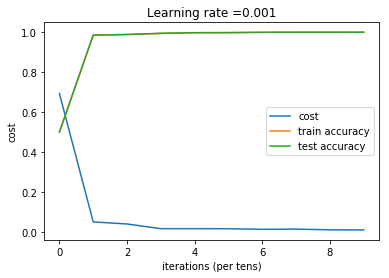

Wall time: 21.5 s


In [141]:
%%time
layer_dims = [train_x.shape[0],128,128,1]
activation = ["relu","relu","sigmoid"]

parameters = L_layer_model_L2(X=train_x,Y=train_y, 
                              layer_dims=layer_dims,
                              activation=activation,
                              initialization='he',
                              keep_prob=.7,
                              mini_batch_size = 512,
                              test_x=test_x, test_y=test_y,
                              learning_rate = .001, lambd=.15, 
                              num_iterations = 100, print_cost = True,
                              optimizer='adam')


In [142]:
predict(train_x, train_y, parameters,activation)

Number of Ones = 4211.0
Accuracy: 0.999762780216


In [143]:
predict(test_x, test_y, parameters,activation)

Number of Ones = 474.0
Accuracy: 0.990384615385


### In this model, it only took 20 seconds which is a small fraction of the 6.5 minutes of the earlier model. It also has a higher training accuracy at 99.99% and a higher testing accuracy at 99.03%. Training and testing accuracy are very close. We can safeley say that we are not overfitting. 